In [5]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from BayesianLLNN import BaseNetwork
from BayesianLLNN import BayesianLastLayer,PredLastLayer,TrainLastLayer
from baseNN import GetNeuralNetwork, PredNormal, TrainNN


In [6]:
np.random.seed(123)
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
#simulate data
X_train = np.random.uniform(-4,4,400).reshape(-1,1).astype(np.float32)
#by adding the gaussian noise we are introducing aleatoric uncertainty
y_train = (X_train**2 + 2*X_train + 0.9* np.random.randn(*X_train.shape)).astype(np.float32)

X_test = np.linspace(-8, 8, 200).reshape(-1, 1).astype(np.float32)
y_test = (X_test**2 + 2*X_test ).astype(np.float32)

tenX = torch.from_numpy(X_train).to(device)
tenY = torch.from_numpy(y_train).to(device)
tenXTest = torch.from_numpy(X_test).to(device)
tenYTest = torch.from_numpy(y_test).to(device)
tenDF = TensorDataset(tenX,tenY)
trainLoader = DataLoader(tenDF,batch_size=32,shuffle=True)
InDist = (X_test >=-4) & (X_test <=4)

Epoch: 0 | Loss: 89.88165
Epoch: 20 | Loss: 1.47215
Epoch: 40 | Loss: 0.91623
Epoch: 60 | Loss: 0.56886
Epoch: 80 | Loss: 0.72559
Epoch: 100 | Loss: 0.74130
Epoch: 120 | Loss: 0.43267
Epoch: 140 | Loss: 1.18813
Epoch: 160 | Loss: 1.03031
Epoch: 180 | Loss: 0.75228
Epoch: 200 | Loss: 0.48165
Epoch: 220 | Loss: 0.82686
Epoch: 240 | Loss: 0.84241
Epoch: 260 | Loss: 1.12331
Epoch: 280 | Loss: 0.83695
Epoch: 300 | Loss: 0.71387
Epoch: 320 | Loss: 0.78174
Epoch: 340 | Loss: 0.81395
Epoch: 360 | Loss: 0.80111
Epoch: 380 | Loss: 1.31401
Epoch: 400 | Loss: 0.66267
Epoch: 420 | Loss: 0.49587
Epoch: 440 | Loss: 0.95033
Epoch: 460 | Loss: 0.59669
Epoch: 480 | Loss: 0.73286
Epoch: 500 | Loss: 0.85578
Epoch: 520 | Loss: 0.53375
Epoch: 540 | Loss: 0.94886
Epoch: 560 | Loss: 0.62149
Epoch: 580 | Loss: 0.68029


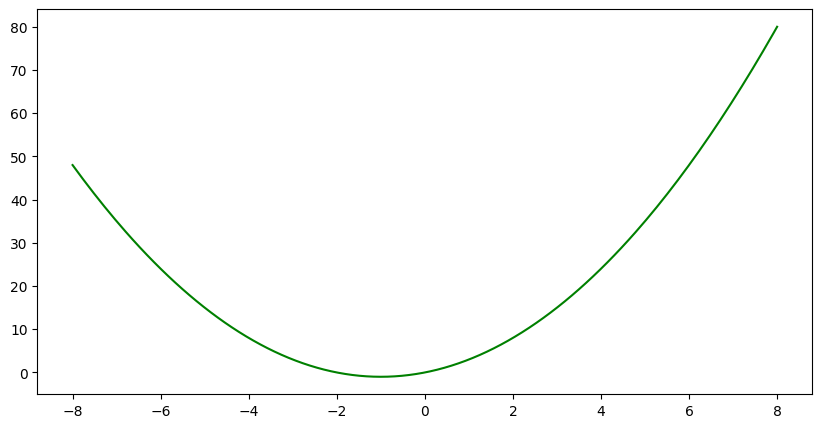

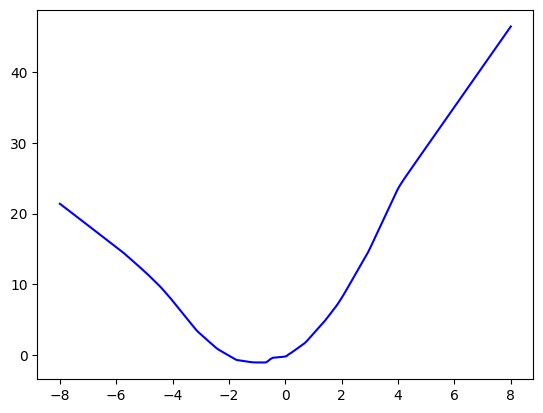

Epoch: 0 | Loss: 76.09268
Epoch: 20 | Loss: 0.87988
Epoch: 40 | Loss: 0.69576
Epoch: 60 | Loss: 0.95834
Epoch: 80 | Loss: 0.91686
Epoch: 100 | Loss: 0.36526
Epoch: 120 | Loss: 0.55972
Epoch: 140 | Loss: 0.69266
Epoch: 160 | Loss: 1.03915
Epoch: 180 | Loss: 0.42776


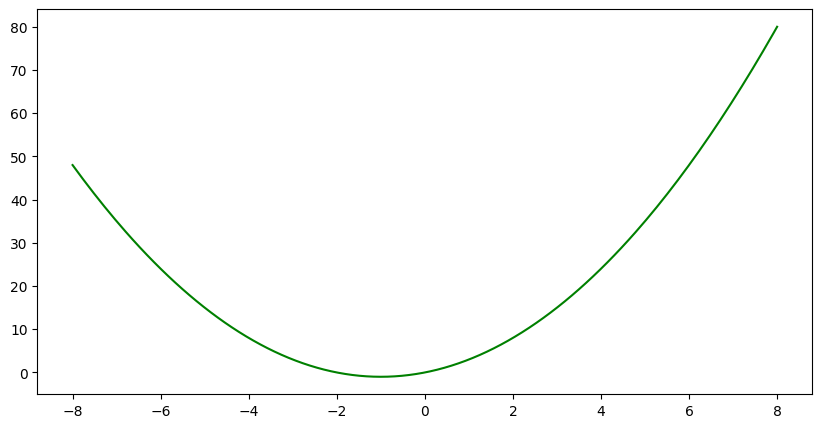

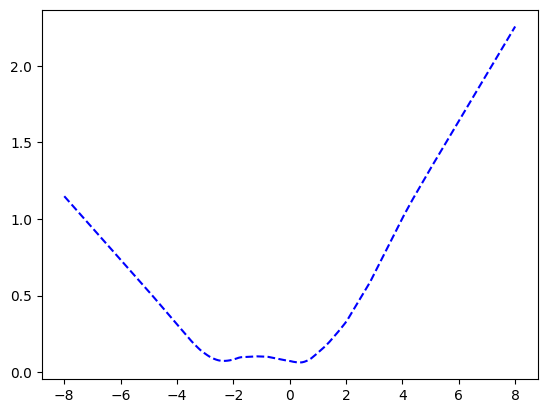

MAP NN: In-dist uncertainty = 0.0000, OOD uncertainty = 0.0000
Bayesian Last Layer: In-dist uncertainty = 0.2631, OOD uncertainty = 1.1937


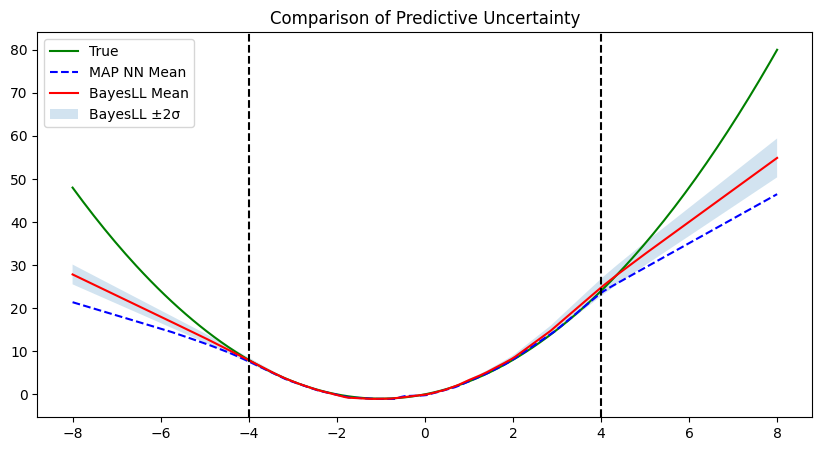

In [7]:
#NO TUNING NOR ANY OPTIMIZATION DONE

#  test run
mapNN = GetNeuralNetwork()
TrainNN(mapNN, trainLoader, epochs=600)
mean_map, std_map = PredNormal(mapNN, tenXTest)
plt.figure(figsize=(10,5))
plt.plot(X_test, y_test, 'g-', label='True')
plt.show()
plt.plot(X_test, mean_map, "b-", label='MAP NN Mean')
plt.show()
# Base + bayesian Last Layer model
base = BaseNetwork().to(device)
head = nn.Linear(16,1).to(device)
baseMod = nn.Sequential(base,head)
TrainNN(baseMod,trainLoader,200)
# freezing base weights
for p in baseMod.parameters():
    p.requires_grad = False
lastLayer = BayesianLastLayer(in_features=16,out_features=1).to(device)
TrainLastLayer(base,lastLayer,trainLoader,epochs=200)
meanB, stdB = PredLastLayer(base,lastLayer,tenXTest)

plt.figure(figsize=(10,5))
plt.plot(X_test,y_test, 'g-', label='True')
plt.show()
# epistemic uncertainty
plt.plot(X_test, stdB, 'b--', label='MAP NN Mean')
plt.show()

mapUnID = std_map[InDist.squeeze()]
mapUnOOD = std_map[~InDist.squeeze()]

bllUnID = stdB[InDist.squeeze()]
bllUnOOD = stdB[~InDist.squeeze()]

print(f"MAP NN: In-dist uncertainty = {mapUnID.mean():.4f}, OOD uncertainty = {mapUnOOD.mean():.4f}")
print(f"Bayesian Last Layer: In-dist uncertainty = {bllUnID.mean():.4f}, OOD uncertainty = {bllUnOOD.mean():.4f}")


plt.figure(figsize=(10,5))
plt.plot(X_test, y_test , 'g-', label='True')
plt.plot(X_test, mean_map, 'b--', label='MAP NN Mean')
plt.plot(X_test, meanB, 'r-', label='BayesLL Mean')
plt.fill_between(X_test.flatten(), meanB-2*stdB, meanB+2*stdB, alpha=0.2, label='BayesLL ±2σ')
plt.axvline(-4, color='k', ls='--')
plt.axvline(4, color='k', ls='--')
plt.legend()
plt.title('Comparison of Predictive Uncertainty')
plt.show()